# Read Bonn data

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/0-Project')

In [ ]:
folders = ['F', 'O', 'S']
dataframes = {}

for folder_path in folders:
  file_list = os.listdir(folder_path)
  data_dict = {}

  for file_name in file_list:
    column_name = file_name[1:4]
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
      file_data = [line.strip() for line in file.readlines()]
      data_dict[column_name] = file_data

  df = pd.DataFrame(data_dict)
  df = df[sorted(df.columns)]

  # Store the DataFrame in the dictionary with the folder name as the key
  dataframes[folder_path] = df

# Accessing the DataFrames for F, O, and S
df_F = dataframes['F']
df_O = dataframes['O']
df_S = dataframes['S']

df_F = df_F.apply(pd.to_numeric)
df_O = df_O.apply(pd.to_numeric)
df_S = df_S.apply(pd.to_numeric)


# Implement L2SB algorithm



In [ ]:
def compare(str1, str2):
  '''
  Compare str1 and str2, both are 12-bit binary representation, separate them
  in 3 nibbles, nibble 1, 2, 3.
  If all nibbles are different, return '11'
  If nibble 1 is the same, return '10'
  If nibble 1 and 2 are the same, return '01'
  If all nibbles are the same, return '00'
  '''
  # Ensure both strings are 12-bit binary representations
  if len(str1) != 12 or len(str2) != 12:
    raise ValueError("Both strings must be 12-bit binary representations.")

  # Split the strings into 3 nibbles
  nibbles1 = [str1[:4], str1[4:8], str1[8:]]
  nibbles2 = [str2[:4], str2[4:8], str2[8:]]

  # Compare the nibbles
  if nibbles1 == nibbles2:
    return '00'
  elif nibbles1[0] == nibbles2[0] and nibbles1[1] == nibbles2[1]:
    return '01'
  elif nibbles1[0] == nibbles2[0]:
    return '10'
  else:
    return '11'

In [ ]:
def l2sb(input):
  '''
  Params:
    input :  a list of 12-bit binary string
  Use L2SB algorithm and return a list of compressed result.
  '''
  res = []
  res.append(input[0])
  for i in range(1, len(input)):
    code = compare(input[i], input[i-1])
    if code == '11':
      res.append('11' + input[i])
    elif code == '10':
      res.append('10' + input[i][4:])
    elif code == '01':
      res.append('01' + input[i][8:])
    else:
      res.append('00')
  return res


# Test L2SB algorithm

In [ ]:
input = ['000001100100', '000001100100', '000011101100', '000011101000', '000011101000', '010010101010']
#           1-2-3           all same          1 same          1-2 same       all same     all different
#  header     none             00               10            01               00             11

In [ ]:
# test case
res = l2sb(input)
print(res)

['000001100100', '00', '1011101100', '011000', '00', '11010010101010']


# Calculate compression ratio

In [ ]:
def total_length(strings):
  '''
  Params:
    strings : a list of string
  Return the total length of all strings in input string.
  '''
  return sum(len(s) for s in strings)

In [ ]:
def calRatio_avg(input):
  '''
  Params:
    input : a data frame, each column represents a txt file

  Use l2sb algorithm to compress the input data. Calculate compress ratio of each
  column, then calculate the average ratio of all columns as the final result.
  '''
  ratios = []
  for i in range(input.shape[1]):
    col = input.iloc[:,i]
    binarycol = [np.binary_repr(val, width=12) for val in col]
    col_compressed = l2sb(binarycol)
    ratios.append(total_length(binarycol) / total_length(col_compressed))
  return sum(ratios)/len(ratios), ratios

def calRatio_all(input):
  '''
  Params:
    input : a data frame, each column represents a txt file

  Use l2sb algorithm to compress the input data. Record the length of compressed
  and original data of each column, then sum the compressed and original length
  of all data to get the overall compress ratio.
  '''
  original_length = 0
  compressed_length = 0
  for i in range(input.shape[1]):
    col = input.iloc[:,i]
    binarycol = [np.binary_repr(val, width=12) for val in col]
    col_compressed = l2sb(binarycol)
    original_length += total_length(binarycol)
    compressed_length += total_length(col_compressed)
  return original_length / compressed_length


# Find the best offset

In [ ]:
def calculate_ratios(df, num_steps):
  '''
  Params:
    df        : input data frame
    num_steps : number of steps from min to 2048
  This function calcualtes the ratio when we add different offset to original data.
  The minimum offset guarantees we have all positive data. The largest offset is
  2048 because we use 12-bit binary number to represent data and the maximum in
  original data is 2048.
  '''
  start = -df.min().min()
  end = 2048
  step_size = (end - start) // (num_steps - 1)
  ratios = []
  x_axis = []
  temp_df = df.copy()
  temp_df += start

  for i in range(num_steps):
    current_offset = start + i * step_size
    x_axis.append(current_offset)
    ratios.append(calRatio_all(temp_df))
    temp_df += step_size

  return x_axis, ratios

In [ ]:
def plotRatio(x_axis, ratios):
  # plot the ratio and offset diagram
  plt.figure(figsize=(12, 6))
  plt.plot(x_axis, ratios, marker='o', linestyle='-', color='b', label='Compression ratio')
  plt.title('Compression ratio under different offsets of Seizure data')
  plt.xlabel('Offset')
  plt.ylabel('Compression Ratio')
  plt.legend()
  plt.grid(True)

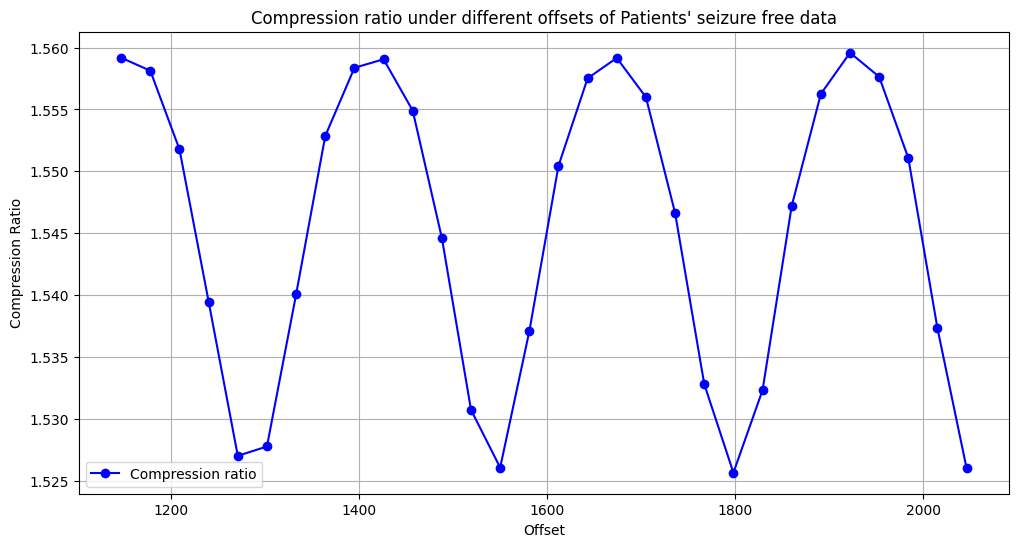

In [ ]:
num_steps = 30
x_axisf, ratios_f = calculate_ratios(df_F, num_steps) #Patients\' seizure free
plotRatio(x_axisf, ratios_f)

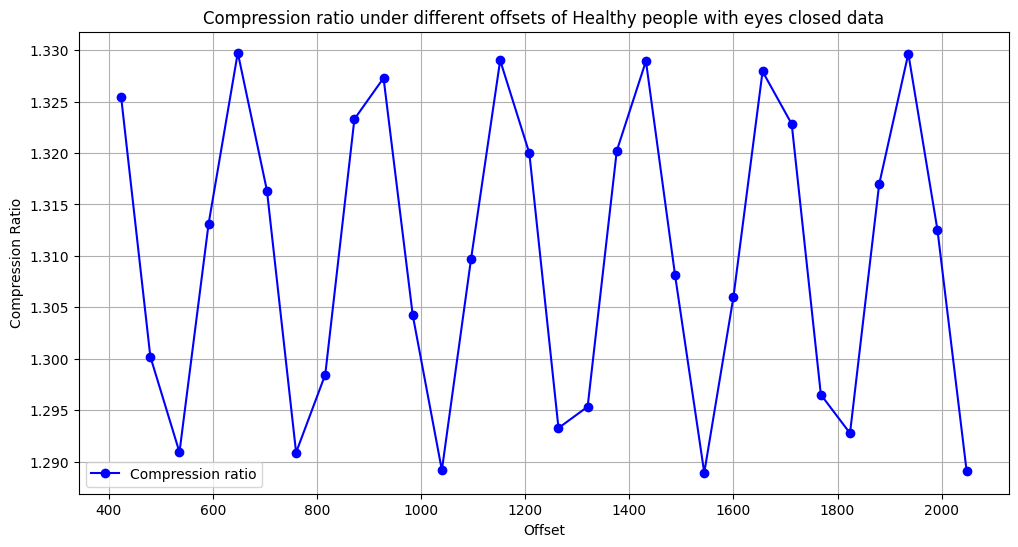

In [ ]:
num_steps = 30
x_axiso, ratios_o = calculate_ratios(df_O, num_steps) #Healthy people with eyes closed

plotRatio(x_axiso, ratios_o)

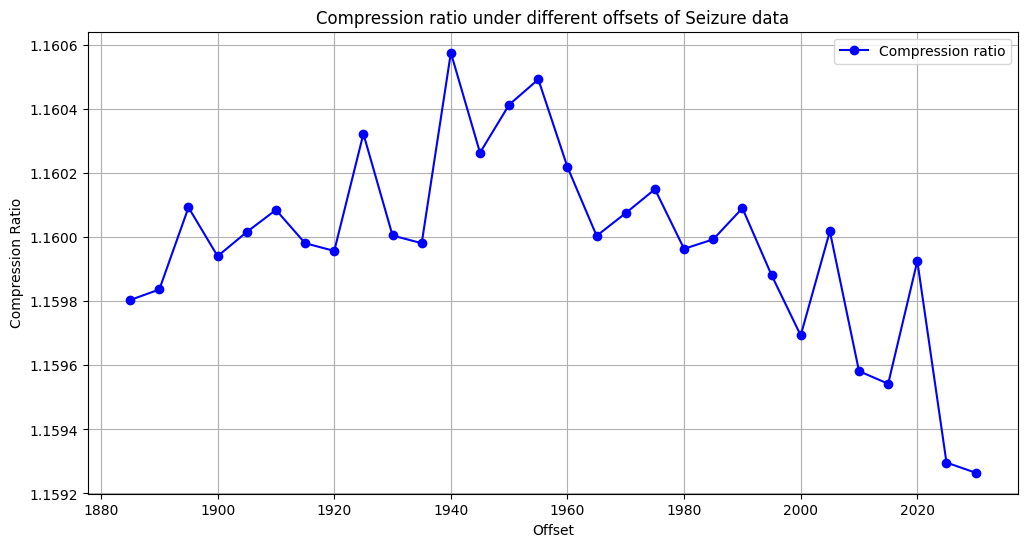

In [ ]:
num_steps = 30
x_axisS, ratios_S = calculate_ratios(df_S, num_steps) # Seizure data

plotRatio(x_axisS, ratios_S)

So, the seizure data is different from other two datasets. In other two datasets, we can choose the -min value of the dataset as our offset, but in seizure dataset, the -min value is not the best offset. The ratio difference in seizure dataset is trivial (0.001), but in other two, they are relatively larger (0.03).

# Transfer data to given range

Let's assume the data set has a range of [min, max], then for every data point in it, we use the following equation to transfer it into our desired range:

4095 * data[i] / (max - min)

We use 4095 because 2^12 = 4096, a 12 bit binary number is in range [0,4095]

In [ ]:
def transfer(data):
  '''
  Params:
    data : input data frame
  First we add offset to input data frame so we have a dataset of non-negative numbers.
  Transfer the data using following equation:
  new_data = 4095 * data[i] / (max - min)
  '''
  new_data = data.copy()
  min = data.min().min()
  if min < 0:
    new_data -= min
  min = new_data.min().min()
  max = new_data.max().max()
  new_data = 4095 * new_data / (max - min)
  new_data = new_data.round().astype(int)
  return new_data

In [ ]:
df_F_new = transfer(df_F)
df_O_new = transfer(df_O)
df_S_new = transfer(df_S)
ratio_f = calRatio_all(df_F_new)
ratio_o = calRatio_all(df_O_new)
ratio_s = calRatio_all(df_S_new)

1.48273698940816 1.0672504083268282 1.1541603673480887


# Results comparison

original data F is in [-1147, 2047], using above data transfer equation did not result in better compress ratio.

Data source |  scaled result | min as offset | no offset
--- | --- | --- | --
F |  1.483 | 1.559 | 1.527
O |  1.067 | 1.325 | 1.289
S |  1.154 | 1.16 | 1.159

Using min as offset results in higher CR

dataset | min vs no offset |  min vs scaled result
-- | -- | --
F|2.09% | 5.12%
O|2.79% | 24.18%
S|0.09% | 0.52%


In [ ]:
df_f_temp = df_F.copy()
df_o_temp = df_O.copy()
df_s_temp = df_S.copy()
ratio_f_no_offset = calRatio_all(df_f_temp)
ratio_o_no_offset = calRatio_all(df_o_temp)
ratio_s_no_offset = calRatio_all(df_s_temp)
print(f'ratio_f_no_offset: {ratio_f_no_offset}')
print(f'ratio_o_no_offset: {ratio_o_no_offset}')
print(f'ratio_s_no_offset: {ratio_s_no_offset}')


ratio_f_no_offset: 1.5269536956975462
ratio_o_no_offset: 1.2890782319774465
ratio_s_no_offset: 1.1590209568641652


In [ ]:
df_F_min_as_offset = df_F.copy()
df_F_min_as_offset -= df_F_min_as_offset.min().min()
ratio_f = calRatio_all(df_F_min_as_offset)
print(ratio_f)
df_O_min_as_offset = df_O.copy()
df_O_min_as_offset -= df_O_min_as_offset.min().min()
ratio_o = calRatio_all(df_O_min_as_offset)
print(ratio_o)
df_S_min_as_offset = df_S.copy()
df_S_min_as_offset -= df_S_min_as_offset.min().min()
ratio_s = calRatio_all(df_S_min_as_offset)
print(ratio_s)

1.5591819337357193
1.3254095602888274
1.1598040288823381


# Plot every txt file's compress ratio


In [ ]:
f_avg = df_F.copy()
o_avg = df_O.copy()
s_avg = df_S.copy()
f_avg -= df_F.values.min();
o_avg -= df_O.values.min();
s_avg -= df_S.values.min();
avg_f, ratio_f = calRatio_avg(f_avg)
avg_o, ratio_o = calRatio_avg(o_avg)
avg_s, ratio_s = calRatio_avg(s_avg)


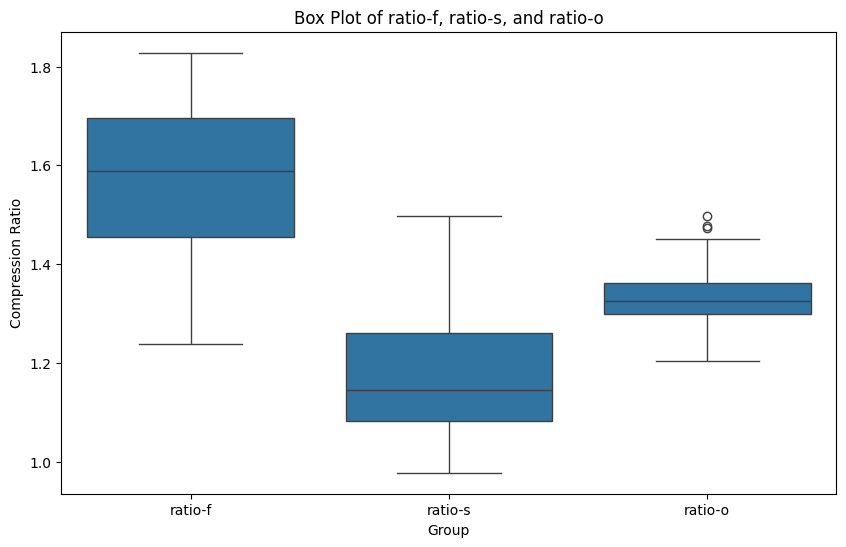

In [ ]:
df = pd.DataFrame({
    'Group': np.repeat(['ratio-f', 'ratio-s', 'ratio-o'], 100),
    'Value': np.concatenate([ratio_f, ratio_s, ratio_o])
})
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Value', data=df)
plt.title('Box Plot of ratio-f, ratio-s, and ratio-o')
plt.ylabel('Compression Ratio')
plt.xlabel('Group')
plt.show()

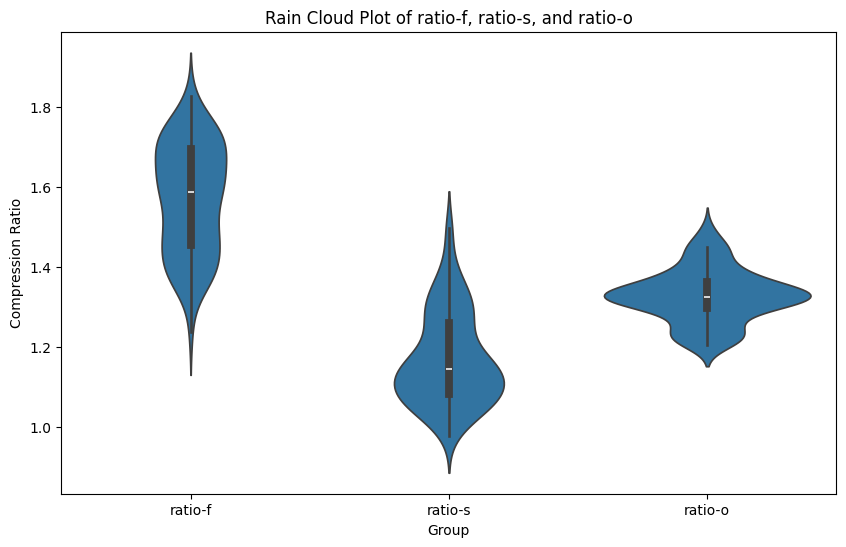

In [ ]:
# Rain cloud plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Value', data=df)
plt.title('Rain Cloud Plot of ratio-f, ratio-s, and ratio-o')
plt.ylabel('Compression Ratio')
plt.xlabel('Group')
plt.show()

It seems that the compression ratio of most seizure data is lower than that of the other two groups. But we need more dataset to obtain a more reliable conclusion.

# New L2SB algorithm

In original paper, we split 12 bits into {4, 4, 4} nibbles. Here we keep the number of nibbles to 3 and list all possible combinations.

In [ ]:
def compare_new(str1, str2, split):
  '''
  Params:
    str1  : input string 1
    str2  : input string 2
    split : a list of 3 integers sum up to 12

  Compare str1 and str2, both are 12-bit binary representation, separate them
  in 3 nibbles, nibble 1, 2, 3 using split
  If all nibbles are different, return '11'
  If nibble 1 is the same, return '10'
  If nibble 1 and 2 are the same, return '01'
  If all nibbles are the same, return '00'
  '''
  # Ensure both strings are 12-bit binary representations
  if len(str1) != 12 or len(str2) != 12:
    raise ValueError("Both strings must be 12-bit binary representations.")

  # Split the strings into 3 nibbles
  nibbles1 = [str1[:split[0]], str1[split[0]:(split[1] + split[0])], str1[(split[1] + split[0]):]]
  nibbles2 = [str2[:split[0]], str2[split[0]:(split[1] + split[0])], str2[(split[1] + split[0]):]]

  # Compare the nibbles
  if nibbles1 == nibbles2:
    return '00'
  elif nibbles1[0] == nibbles2[0] and nibbles1[1] == nibbles2[1]:
    return '01'
  elif nibbles1[0] == nibbles2[0]:
    return '10'
  else:
    return '11'

In [ ]:
def l2sb_new(input, split):
  '''
  Params:
    input : a list of 12-bit binary string
    split : a list of 3 integers sum up to 12
  Use L2SB algorithm and return a list of compressed result.
  '''
  res = []
  res.append(input[0])
  for i in range(1, len(input)):
    if compare_new(input[i], input[i-1], split) == '11':
      res.append('11' + input[i])
    elif compare_new(input[i], input[i-1], split) == '10':
      res.append('10' + input[i][split[0]:])
    elif compare_new(input[i], input[i-1], split) == '01':
      res.append('01' + input[i][(split[1] + split[0]):])
    else:
      res.append('00')
  return res


In [ ]:
def calRatio_all_new(input, split):
  '''
  Params:
    input : a data frame, each column represents a txt file
    split : a list of 3 integers sum up to 12

  Use new l2sb algorithm to compress the input data. Record the length of compressed
  and original data of each column, then sum the compressed and original length
  of all data to get the overall compress ratio.
  '''
  original_length = 0
  compressed_length = 0
  for i in range(input.shape[1]):
    col = input.iloc[:,i]
    binarycol = [np.binary_repr(val, width=12) for val in col]
    col_compressed = l2sb_new(binarycol, split)
    original_length += total_length(binarycol)
    compressed_length += total_length(col_compressed)
  return original_length / compressed_length


# Test new L2SB algorithm

In [ ]:
input = ['000001100100', '000001100100', '001001101100', '001001101000', '101101101001']
#             none            all same        1-same        1-2 same        all different
#                                00              10            01                11
split = [2,6,4]
print(l2sb_new(input, split))

['000001100100', '00', '101001101100', '011000', '11101101101001']


# Explore all combinations

In [ ]:
# Get all possible combinations of splitting
combinations = []
for x in range(1, 11):
  for y in range(1, 12-x):
    z = 12 - x - y
    if z > 0:
      combinations.append([x, y, z])

In [ ]:
f_temp = df_F.copy()
o_temp = df_O.copy()
s_temp = df_S.copy()
f_temp -= f_temp.min().min()
o_temp -= o_temp.min().min()
s_temp -= s_temp.min().min()

In [ ]:
f_res_dict = {}
o_res_dict = {}
s_res_dict = {}
for split in combinations:
  ratio_f = calRatio_all_new(f_temp, split)
  f_res_dict[tuple(split)] = ratio_f
  ratio_o = calRatio_all_new(o_temp, split)
  o_res_dict[tuple(split)] = ratio_o
  ratio_s = calRatio_all_new(s_temp, split)
  s_res_dict[tuple(split)] = ratio_s


In [ ]:
f_top5 = dict(sorted(f_res_dict.items(), key=lambda item: item[1], reverse=True)[:5])
print(f_top5)

{(6, 2, 4): 1.589856788711771, (5, 3, 4): 1.5883528544410492, (4, 3, 5): 1.5734982491615466, (5, 2, 5): 1.5635241307261878, (6, 3, 3): 1.5632323080728847}


In [ ]:
o_top5 = dict(sorted(o_res_dict.items(), key=lambda item: item[1], reverse=True)[:5])
print(o_top5)

{(4, 3, 5): 1.3794763747414744, (4, 2, 6): 1.377565773694109, (5, 2, 5): 1.3727216935483422, (5, 3, 4): 1.3491782098553347, (3, 3, 6): 1.3435984355839874}


In [ ]:
s_top5 = dict(sorted(s_res_dict.items(), key=lambda item: item[1], reverse=True)[:5])
print(s_top5)

{(3, 3, 6): 1.187279274823613, (4, 2, 6): 1.1850402051717157, (4, 3, 5): 1.180370187369722, (3, 2, 7): 1.1802953763361868, (3, 4, 5): 1.1656567974833725}


(4, 3, 5) has good performance for all datasets.

Next we can try to separate the data into 2, 4, 5 or more nibbles. We also need to try our algorithm on other datasets.

# Draw box plot of 3 nibbles

Choose dataset O as our example, plot the CR of every combination of 3 nibbles.

Export the result into a excel or csv file.

In [ ]:
import openpyxl
from openpyxl import Workbook

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Write the headers
ws.append(['Key', 'Value'])

# Write the key-value pairs
for key, value in o_res_dict.items():
  ws.append([str(key), value])


# Save the workbook to a file
wb.save('O-output-3.xlsx')



Then we export the result of F and S too.

In [ ]:
import openpyxl
from openpyxl import Workbook

wb = Workbook()
ws_f = wb.active
ws_f.title = 'Ratio List F'
ws_o = wb.create_sheet(title='Ratio List O')
ws_s = wb.create_sheet(title='Ratio List S')
ws_f.append(['Key', 'Value'])
ws_o.append(['Key', 'Value'])
ws_s.append(['Key', 'Value'])

for key, value in f_res_dict.items():
  ws_f.append([str(key), value])

for key, value in o_res_dict.items():
  ws.append([str(key), value])

for key, value in s_res_dict.items():
  ws_s.append([str(key), value])

wb.save('3 nibbles.xlsx')
